In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler
import time
import os
from tempfile import TemporaryDirectory

df = pd.read_csv('../data/ds_salaries_cleaned.csv')

In [19]:
print(df.shape)
df.head()

(3755, 9)


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior-level/Expert,Full-Time,Data Scientist,85847,ES,100,ES,L
1,2023,Mid-level/Intermediate,Contract,ML Engineer,30000,US,100,US,S
2,2023,Mid-level/Intermediate,Contract,ML Engineer,25500,US,100,US,S
3,2023,Senior-level/Expert,Full-Time,Data Scientist,175000,CA,100,CA,M
4,2023,Senior-level/Expert,Full-Time,Data Scientist,120000,CA,100,CA,M


In [20]:
# see the type of each column
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [13]:
df["job_title"].value_counts()

job_title
Data Engineer                1110
Data Scientist                935
Data Analyst                  744
Machine Learning Engineer     333
Analytics Engineer            118
Applied Scientist             113
Data Science Manager          111
Data Architect                105
Research Scientist             93
Research Engineer              59
ML Engineer                    34
Name: count, dtype: int64

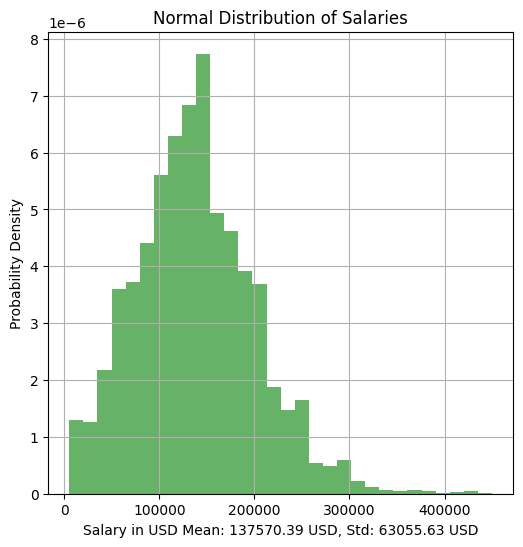

In [21]:
# draw a normalized histogram of the salary
import matplotlib.pyplot as plt
mean = df['salary_in_usd'].mean()
std = df['salary_in_usd'].std()

plt.figure(figsize=(6, 6))
# bins 有多少個直方圖的柱子bins數量; density做歸一化保持圖片面積為1; alpha透明度
plt.hist(df['salary_in_usd'], bins=30, density=True, alpha=0.6, color='g')
plt.title('Normal Distribution of Salaries')
plt.xlabel('Salary in USD Mean: {:.2f} USD, Std: {:.2f} USD'.format(mean, std))
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [31]:
# calculate the percentiles
percentiles = np.percentile(df['salary_in_usd'], [25, 50, 75])  # 25th, 50th, 75th 分位數
print(percentiles)
# define the labels of saraly levels 
labels = ['Level 1', 'Level 2', 'Level 3', 'Level 4']

# print the meaning of label 
for i in range(len(labels)):
    if i == 0:
        print('Level 1: < {:.2f} USD'.format(percentiles[i]))
    elif i == len(labels) - 1:
        print('Level {}: > {:.2f} USD'.format(i+1, percentiles[i-1]))
    else:
        print('Level {}: {:.2f} ~ {:.2f} USD'.format(i+1, percentiles[i-1], percentiles[i]))


#  -np.inf, np.inf be the lower and upper bounds of the bins
# *percentiles: base on the percentiles to cut the bins and generate the salary levels for being the labels of training data
df['salary_level'] = pd.cut(df['salary_in_usd'], bins=[-np.inf, *percentiles, np.inf], labels=labels)
data = df.drop(['salary_in_usd'], axis=1) # we cannot put the label into the training data
print("\nThe data of each salary level is balanced.")
print(data['salary_level'].value_counts())

[ 95000. 135000. 175000.]
Level 1: < 95000.00 USD
Level 2: 95000.00 ~ 135000.00 USD
Level 3: 135000.00 ~ 175000.00 USD
Level 4: > 175000.00 USD

The data of each salary level is balanced.
salary_level
Level 2    967
Level 1    956
Level 4    932
Level 3    900
Name: count, dtype: int64


In [ ]:
# each number of salary level have approximately the same number of data which occupy 25% of the whole data

In [25]:
class SalaryDataset(Dataset):

    # 初始化函數，用於載入和預處理數據
    def __init__(self, data, train=True, transform=None):
        # train 參數用於指示是訓練數據還是測試數據
        self.train = train

        # 創建 MinMaxScaler 和 OneHotEncoder 來進行數據預處理
        minmax_scaler = MinMaxScaler()
        onehot_enc = OneHotEncoder()

        # 將數據分為類別特徵、數值特徵和標籤
        categorical_features = data[data.select_dtypes(include=['object']).columns]
        numerical_features = data[data.select_dtypes(exclude=['object']).columns].drop('salary_level', axis=1)
        label_features = data[['salary_level']]

        # 對數值特徵進行歸一化（MinMax 歸一化）
        numerical_features_arr = minmax_scaler.fit_transform(numerical_features)

        # 對類別特徵進行獨熱編碼
        categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

        # 對類別特徵進行one-hot編碼後，獲取編碼後的特徵名稱
        label_features = onehot_enc.fit_transform(label_features).toarray()

        # 將歸一化的數值特徵和獨熱編碼後的類別特徵合併成一個數據集
        combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=label_features)], axis=1).reset_index(drop=True)

        # 將數據集分為訓練集和測試集
        train_data, test_data = train_test_split(combined_features, test_size=0.2, random_state=42)

        # 根據訓練或測試模式選擇要使用的數據
        if train:
            self.data = train_data
        else:
            self.data = test_data

    # 返回數據集的長度
    def __len__(self):
        return len(self.data)

    # 用於訓練神經網絡的函數，返回特徵和標籤
    def __getitem__(self, idx):
        # 獲取在 self.data DataFrame 中的第 idx 行的數據
        sample = self.data.iloc[idx] 
        # 將一個數據結構轉換為 PyTorch 張量 並指定這個张量的數據類型為浮點數（float）
        features = torch.FloatTensor(sample[:-4])
        label = torch.FloatTensor(sample[-4:])
        return features, label

    # 返回整個數據集的 DataFrame
    def getData(self):
        return self.data


In [26]:
train_dataset = SalaryDataset(data, train=True) 
test_dataset = SalaryDataset(data, train=False)
print('train_dataset len:', len(train_dataset))
print('val_dataset len:', len(test_dataset))
print('total_dataset len:', len(train_dataset) + len(test_dataset))

train_dataset len: 3004
val_dataset len: 751
total_dataset len: 3755


In [35]:
test_dataset.getData().shape

(751, 178)

In [13]:
df

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_level
0,2023,Senior-level/Expert,Full-Time,Principal Data Scientist,ES,100,ES,L,Level 1
1,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
2,2023,Mid-level/Intermediate,Contract,ML Engineer,US,100,US,S,Level 1
3,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 3
4,2023,Senior-level/Expert,Full-Time,Data Scientist,CA,100,CA,M,Level 2
...,...,...,...,...,...,...,...,...,...
3750,2020,Senior-level/Expert,Full-Time,Data Scientist,US,100,US,L,Level 4
3751,2021,Mid-level/Intermediate,Full-Time,Principal Data Scientist,US,100,US,L,Level 3
3752,2020,Entry-level/Junior,Full-Time,Data Scientist,US,100,US,S,Level 2
3753,2020,Entry-level/Junior,Contract,Business Data Analyst,US,100,US,L,Level 2


In [32]:
dataloaders = {'train': train_dataset, 'test': test_dataset}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 3004, 'test': 751}

In [33]:


def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else: 
                    model.eval()
                
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs_vector, labels_vector in dataloaders[phase]:

                    # zero the parameter gradients 
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs_vector) # (e.g. tensor([[-1.3948, -1.4476, -1.3804, -1.3261]]))

                        # ===== !!! Here !!! ====== 
                        pred = torch.argmax(outputs).item() # (e.g. 2)
                        result = torch.argmax(labels_vector).item() # (e.g. 2) 
                        loss = criterion(outputs, labels_vector) # 
                        # ===== !!! End !!! ====== 

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item()
                    if pred == result:
                        running_corrects += 1

                if phase == 'train':
                    scheduler.step()
                # 計算每個 epoch 的 loss 和 accuracy 
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time elapsed: {round((time.time() - since))} sec.')
                
                # if found a better accuracy, save the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights 然後執行下一個 epoch 
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [43]:
# Step 3: Create a neural network model
class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 4)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x


In [44]:
D_in, D_out = 174, 4
n_epochs = 2
# model = MultiLayerNet(D_in, D_out, neurons= 512, num_layers=5)

model = SalaryPredictor(D_in)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
model = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3884 Acc: 0.2590 Time elapsed: 4 sec.
test Loss: 1.3878 Acc: 0.2597 Time elapsed: 5 sec.

Epoch 1/24
----------
train Loss: 1.3873 Acc: 0.2636 Time elapsed: 9 sec.
test Loss: 1.3848 Acc: 0.2597 Time elapsed: 9 sec.

Epoch 2/24
----------
train Loss: 1.3166 Acc: 0.3459 Time elapsed: 13 sec.
test Loss: 1.2285 Acc: 0.4088 Time elapsed: 14 sec.

Epoch 3/24
----------
train Loss: 1.1759 Acc: 0.4298 Time elapsed: 18 sec.
test Loss: 1.1684 Acc: 0.4554 Time elapsed: 18 sec.

Epoch 4/24
----------
train Loss: 1.1495 Acc: 0.4381 Time elapsed: 22 sec.
test Loss: 1.1539 Acc: 0.4847 Time elapsed: 23 sec.

Epoch 5/24
----------
train Loss: 1.1365 Acc: 0.4574 Time elapsed: 27 sec.
test Loss: 1.1541 Acc: 0.4794 Time elapsed: 27 sec.

Epoch 6/24
----------
train Loss: 1.1261 Acc: 0.4704 Time elapsed: 31 sec.
test Loss: 1.1450 Acc: 0.4834 Time elapsed: 32 sec.

Epoch 7/24
----------
train Loss: 1.0989 Acc: 0.4883 Time elapsed: 36 sec.
test Loss: 1.1165 Acc: 0.4727 Tim

In [19]:
# save the model to disk 
torch.save(model.state_dict(), '../data/model/salary_pred.pt')

In [20]:
class InputDataSource(Dataset):

    # 初始化函數，用於載入和預處理數據
    def __init__(self, data):
        # 創建 MinMaxScaler 和 OneHotEncoder 來進行數據預處理
        minmax_scaler = MinMaxScaler()
        onehot_enc = OneHotEncoder()
        
        # 將數據分為類別特徵、數值特徵和標籤
        categorical_features = data[data.select_dtypes(include=['object']).columns]
        numerical_features = data[data.select_dtypes(exclude=['object']).columns].drop('salary_level', axis=1)
        label_features = data[['salary_level']]

        # 對數值特徵進行歸一化（MinMax 歸一化）
        numerical_features_arr = minmax_scaler.fit_transform(numerical_features)

        # 對類別特徵進行獨熱編碼
        categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

        # 對類別特徵進行one-hot編碼後，獲取編碼後的特徵名稱
        label_features = onehot_enc.fit_transform(label_features).toarray()

        # 將歸一化的數值特徵和獨熱編碼後的類別特徵合併成一個數據集
        combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
        combined_features = pd.concat([combined_features, pd.DataFrame(data=label_features)], axis=1).reset_index(drop=True)
        self.data = combined_features

    # 返回數據集的長度
    def __len__(self):
        return len(self.data)

    # 用於訓練神經網絡的函數，返回特徵和標籤
    def __getitem__(self, idx):
        # 獲取在 self.data DataFrame 中的第 idx 行的數據
        sample = self.data.iloc[idx] 
        # 將一個數據結構轉換為 PyTorch 張量 並指定這個张量的數據類型為浮點數（float）
        features = torch.FloatTensor(sample[:-4])
        label = torch.FloatTensor(sample[-4:])
        return features, label

    # 返回整個數據集的 DataFrame
    def getData(self):
        return self.data


In [21]:
input = {
    'work_year': 2023,
    'experience_level': 'Senior-level/Expert',
    'employment_type': 'Full-Time',
    'job_title': 'Principal Data Scientist',
    # 'salary_in_usd': 85847,
    'employee_residence': ['ES'],
    'remote_ratio': [100],
    'company_location': ['ES'],
    'company_size': ['L'],
    'salary_level': ['Level 1']
}

df = pd.DataFrame(input)
print(df)

   work_year     experience_level employment_type                 job_title  \
0       2023  Senior-level/Expert       Full-Time  Principal Data Scientist   

  employee_residence  remote_ratio company_location company_size salary_level  
0                 ES           100               ES            L      Level 1  
